# Chess Game Classification - EECS 731 Final Project
"The Outliers" - Patrick Canny & Mason Wilde

## Background
We set out to use our knowledge of Data Science to create a classification system for chess games. Chess is a fairly complicated game, with 10^120 games possible.

## Initial Data Exploration

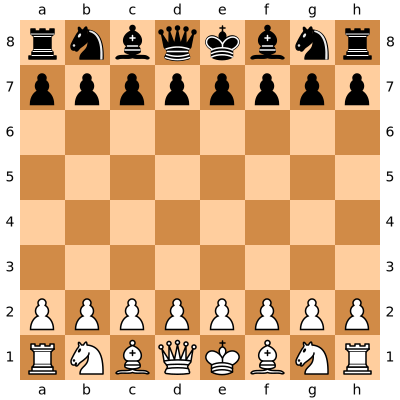

In [1]:
import chess
board = chess.Board()
board

In [2]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data into inital dataframes
df = pd.read_csv("../data/csv/games.csv")

In [4]:
# Initial Look at our data
df.shape

(20058, 16)

In [5]:
pd.set_option('display.width', 10)
df.columns

Index(['id',
       'rated',
       'created_at',
       'last_move_at',
       'turns',
       'victory_status',
       'winner',
       'increment_code',
       'white_id',
       'white_rating',
       'black_id',
       'black_rating',
       'moves',
       'opening_eco',
       'opening_name',
       'opening_ply'],
      dtype='object')

A fairly small starter dataset to start with. Initially, some of the more interesting column names include: 
- **opening_name**: this feature could be used to determine what the most effective entry is for each color
- **winner**: this is what we will be predicting, but the column could also be used to get some general stats about how successful each color is given a variety of filters
- **moves**: this will give us an idea of how frequently given moves are made in the game, but we may have some issues interpereting them
- **rated**: interestingly, we could see if rated games are more contested than non-rated games.
- **created_at/last_move_at**: this can give us the total time of a given game

In [6]:
df['created_at'] = df['created_at'].astype('int64')
df['last_move_at'] = df['last_move_at'].astype('int64')
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1504210000000,1504210000000,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1504130000000,1504130000000,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1504130000000,1504130000000,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1504110000000,1504110000000,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1504030000000,1504030000000,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [7]:
# Create Game Length feature
df["game_length"] = df["last_move_at"] - df["created_at"]

In [8]:
len(df['game_length'].nonzero()[0])

11510

It appears that about half of the games in this dataset have a non-zero game length, which is not exactly what we want to see.

In [9]:
timed = df[df['game_length'] != 0]

In [10]:
# Split dataframe into white winners and black winners
white = timed[timed['winner'] == 'white']
black = timed[timed['winner'] == 'black']

In [11]:
# Look at the best opening for both white and black
import seaborn as sns
bestOpening_white = white['opening_name'].value_counts()
bestOpening_black = black['opening_name'].value_counts()

In [12]:
b = bestOpening_black.sort_values().tail(5).to_frame()
w = bestOpening_white.sort_values().tail(5).to_frame()

In [13]:
b['opening'] = b.index.tolist()
w['opening'] = w.index.tolist()

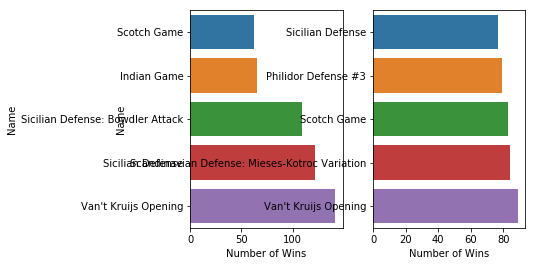

In [14]:
plt.subplot(1, 2, 1)
ax = sns.barplot(x='opening_name', y='opening',data=b)
ax.set(xlabel='Number of Wins', ylabel='Name')

plt.subplot(1, 2, 2)
ax = sns.barplot(x='opening_name', y='opening',data=w)
ax.set(xlabel='Number of Wins', ylabel='Name')


plt.show()

## PGN Format
The next thing we did was install the python-chess package. It has a pretty nice API for interacting with PGN files, which we will need to use in this project

In [15]:
# read a pgn!
import chess.pgn
pgn = open("../data/pgn/lichess_db_standard_rated_2013-01.pgn")

In [16]:
first_game = chess.pgn.read_game(pgn)
games = []
for i in range(0, 1000):
    g = chess.pgn.read_game(pgn)
    games.append(g)

Did some tests to see how to read in a game from a pgn file

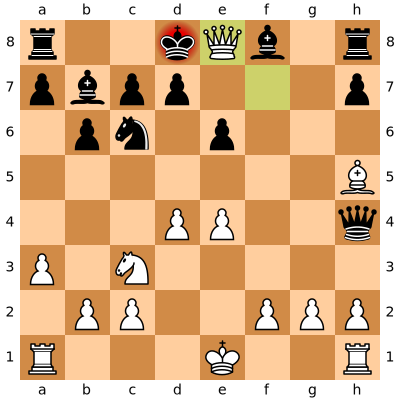

In [17]:
board = first_game.board()
for move in first_game.main_line():
    board.push(move)
board

It looks like we could pretty easily read the headers from every game in a pgn set into a csv/dataframe! 

In [18]:
# iterate through the games and create a pandas dataframe from the headers
df = []
l = []
for header in first_game.headers:
    l.append(header)

for game in games:
    g = []
    for header in game.headers:
        g.append(game.headers[header])
    df.append(g)
print(l)   
lichess = pd.DataFrame(df, columns=l)
lichess

['Event', 'Site', 'Date', 'Round', 'White', 'Black', 'Result', 'BlackElo', 'BlackRatingDiff', 'ECO', 'Opening', 'Termination', 'TimeControl', 'UTCDate', 'UTCTime', 'WhiteElo', 'WhiteRatingDiff']


,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,Opening,Termination,TimeControl,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff
0,Rated Classical game,https://lichess.org/a9tcp02g,????.??.??,?,Desmond_Wilson,savinka59,1-0,1919,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,2012.12.31,23:04:12,1654,+19
1,Rated Classical game,https://lichess.org/szom2tog,????.??.??,?,Kozakmamay007,VanillaShamanilla,1-0,1747,-94,C50,Four Knights Game: Italian Variation,Normal,420+17,2012.12.31,23:03:15,1643,+13
2,Rated Bullet game,https://lichess.org/rklpc7mk,????.??.??,?,Naitero_Nagasaki,800,0-1,1973,+8,B12,Caro-Kann Defense: Goldman Variation,Normal,60+1,2012.12.31,23:04:57,1824,-6
3,Rated Bullet game,https://lichess.org/1xb3os63,????.??.??,?,nichiren1967,Naitero_Nagasaki,0-1,1815,+9,C00,French Defense: La Bourdonnais Variation,Normal,60+1,2012.12.31,23:02:37,1765,-9
4,Rated Blitz game,https://lichess.org/6x5nq6qd,????.??.??,?,sport,shamirbj,1-0,1487,-11,B00,Owen Defense,Time forfeit,300+3,2012.12.31,23:09:21,1477,+12
5,Rated Blitz game,https://lichess.org/fl7asfa0,????.??.??,?,tiggran,arion_6,0-1,1500,+196,C53,"Italian Game: Classical Variation, Giuoco Pian...",Normal,300+0,2012.12.31,23:02:14,1541,-8
6,Rated Classical game,https://lichess.org/7b44wxzu,????.??.??,?,hostking,troepianiz,1-0,1752,-10,C20,English Opening: The Whale,Normal,540+0,2012.12.31,23:06:10,1765,+10
7,Rated Classical game,https://lichess.org/7rzcutsf,????.??.??,?,manos68,jtkjtkful,1-0,1169,-15,A43,Old Benoni Defense,Normal,900+0,2012.12.31,23:03:50,1445,+4
8,Rated Blitz game,https://lichess.org/9opx3qh7,????.??.??,?,adamsrj,hamiakaz,0-1,1428,+14,A40,Englund Gambit Complex: Hartlaub-Charlick Gambit,Normal,180+5,2012.12.31,23:02:48,1522,-14
9,Rated Classical game,https://lichess.org/1hi3aveq,????.??.??,?,BFG9k,Sagaz,0-1,1544,+14,B06,Modern Defense,Normal,600+8,2012.12.31,23:07:33,1644,-16


In [19]:
# now, test the util version
from utils.pgnparser import PGNParser
pgnpath = "../data/pgn/lichess_db_standard_rated_2013-01.pgn"
parser = PGNParser(pgnpath)
new = parser.parse(100)
new

,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,Opening,Termination,TimeControl,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff
0,Rated Classical game,https://lichess.org/j1dkb5dw,????.??.??,?,BFG9k,mamalak,1-0,1403,-8,C00,French Defense: Normal Variation,Normal,600+8,2012.12.31,23:01:03,1639,+5
1,Rated Classical game,https://lichess.org/a9tcp02g,????.??.??,?,Desmond_Wilson,savinka59,1-0,1919,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,2012.12.31,23:04:12,1654,+19
2,Rated Classical game,https://lichess.org/szom2tog,????.??.??,?,Kozakmamay007,VanillaShamanilla,1-0,1747,-94,C50,Four Knights Game: Italian Variation,Normal,420+17,2012.12.31,23:03:15,1643,+13
3,Rated Bullet game,https://lichess.org/rklpc7mk,????.??.??,?,Naitero_Nagasaki,800,0-1,1973,+8,B12,Caro-Kann Defense: Goldman Variation,Normal,60+1,2012.12.31,23:04:57,1824,-6
4,Rated Bullet game,https://lichess.org/1xb3os63,????.??.??,?,nichiren1967,Naitero_Nagasaki,0-1,1815,+9,C00,French Defense: La Bourdonnais Variation,Normal,60+1,2012.12.31,23:02:37,1765,-9
5,Rated Blitz game,https://lichess.org/6x5nq6qd,????.??.??,?,sport,shamirbj,1-0,1487,-11,B00,Owen Defense,Time forfeit,300+3,2012.12.31,23:09:21,1477,+12
6,Rated Blitz game,https://lichess.org/fl7asfa0,????.??.??,?,tiggran,arion_6,0-1,1500,+196,C53,"Italian Game: Classical Variation, Giuoco Pian...",Normal,300+0,2012.12.31,23:02:14,1541,-8
7,Rated Classical game,https://lichess.org/7b44wxzu,????.??.??,?,hostking,troepianiz,1-0,1752,-10,C20,English Opening: The Whale,Normal,540+0,2012.12.31,23:06:10,1765,+10
8,Rated Classical game,https://lichess.org/7rzcutsf,????.??.??,?,manos68,jtkjtkful,1-0,1169,-15,A43,Old Benoni Defense,Normal,900+0,2012.12.31,23:03:50,1445,+4
9,Rated Blitz game,https://lichess.org/9opx3qh7,????.??.??,?,adamsrj,hamiakaz,0-1,1428,+14,A40,Englund Gambit Complex: Hartlaub-Charlick Gambit,Normal,180+5,2012.12.31,23:02:48,1522,-14
